<a href="https://colab.research.google.com/github/uwtintres/robotic_surgeries/blob/main/Fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is used for the Fuzzy TOPSIS implementation. The main idea is to firstly rate the attributes for each alternative by the following scale: 
1.   Very Low (1, 1, 3)
2.   Low (1, 3, 5)
3. Average (3, 5, 7)
4. High (5, 7, 9)
5. Very High (7, 9, 9)

And the numbers in the brackets represent the Fuzzy Numbers. There could be several deceision makers, in our use case, several surgeons could rate the attributes by the scale and the average of their ratings will be used. 
As for how it will be calculated, the word representation of the rating is substituted with the appropriate fuzzy numbers from the brackets. Then, as there will be several decicison matrices (if there are several decision makers - doctors), therefore, to build a combined decision matrix the average will be calculated according to the following logic: x = (a, b, c), where a, b, and c are fuzzy numbers in the brackets; a = is the minimum of all a's from all decision matrices; b = the mean of all b componenets; c = maximum of all c components. 

Now, a combined decision matrix is built and the weights are going to be generated by the same logic - the rating will be provided for each attribute in general and then be substituted by the fuzzy numbers.

Next, the benefit/cost criterias are calculated. The benefit criteria: r = (a/c*, b/c*, c/c*), where c* is the maximum of all the c components for the given attribute. And for the cost criteria: r = (a*/c, a*/b, a*/a), where a* is the minimum of all the a components for the given attribute. 

Next, the weighted normalized fuzzy decision matrix is calculated, where a * a_w, b * b_w, c * c_w and a_w, b_w, c_w are the components of the weight for the current attribute. 

Compute the Fuzzy Positive Ideal Solution (FPIS) and Fuzzy Negative Ideal Solution (FNIS). For FPIS, labeled as A*, the value is the maximum from all the c components within the attribute, if c components are equal, then the values are compared by the b component. As for the FNIS, labeled as A-, the value is the minimum from all a components within the attribute. 

Next, we calculate the distance from all the matrix cell values to the A* and A- values by the formula *sqrt(1/3 * [(a1-a2)^2 + (b1-b2)^2 + (c1-c2)^2])*. And this distance value is then used to calculate the closeness coefficient (CCi) = d-/(d- + d*).

The rank is then generated according to the closeness coefficient, the highest will get higher rank.


The calculation of the ranks is started by uploading the .xslx document with the table of attributes-alternatives' rating, according to the scale above (Very Low - Very High), including the rating of weights. The example of the table is provided below:

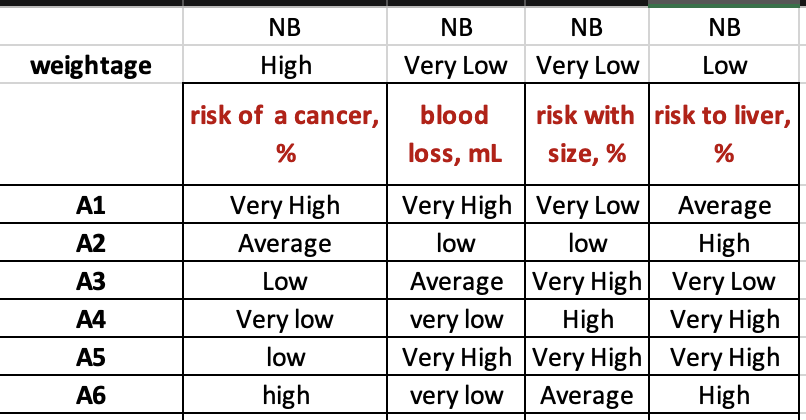




In [1]:
import numpy as np
import pandas as pd
import warnings
import copy
import csv
import matplotlib.pyplot as plt
import heapq

class FuzzyTopsis():
    evaluation_matrix = np.array([])  # Matrix
    weighted_normalized = np.array([])  # Weight matrix
    normalized_decision = np.array([])  # Normalisation matrix
    fuzzy_matrix = np.array([]) # Fuzzy matrix
    fuzzy_weights = np.array([])
    M = 0  # Number of rows
    N = 0  # Number of columns

    definitions_matrix = {'very low': [1, 1, 3],
                   'low': [1, 3, 5],
                   'average': [3, 5, 7],
                   'high': [5, 7, 9],
                   'very high': [7, 9, 9]}
                   
    definitions_weights = {'very low': [1, 1, 3],
                  'low': [1, 3, 5],
                  'average': [3, 5, 7],
                  'high': [5, 7, 9],
                  'very high': [7, 9, 9]}

    '''
	Create an evaluation matrix consisting of m alternatives and n attributes.
	  '''

    def __init__(self, evaluation_matrix, weight_matrix, criteria):

      # M×N matrix
      self.evaluation_matrix = np.array(evaluation_matrix, dtype="object")

      # M alternatives (options)
      self.row_size = len(self.evaluation_matrix)

      # N attributes/criteria
      self.column_size = len(self.evaluation_matrix[0])

      # N size weight matrix
      self.weight_matrix = np.array(weight_matrix, dtype="object")
      #self.weight_matrix = self.weight_matrix/sum(self.weight_matrix)
      self.criteria = np.array(criteria, dtype="object")
    '''
	# Step 2
	The word representation of ratings converted to fuzzy numbers
	'''
    def step_2(self):
        self.fuzzy_matrix = np.empty(shape=(self.row_size,self.column_size),dtype="object")
        self.fuzzy_weights = np.empty(shape=(1, self.column_size),dtype="object")
        #self.fuzzy_matrix = np.copy(self.evaluation_matrix)
        # Substituting words with fuzzy numbers for fuzzy matrix
        for i in range(self.row_size):
          for j in range(self.column_size):
            if self.evaluation_matrix[i,j].lower() in self.definitions_matrix:
              self.fuzzy_matrix[i,j] = self.definitions_matrix[self.evaluation_matrix[i,j].lower()]
            else:
              print("Wrong rating for cell [", i, j, "]")
              break
        # Substituting words with fuzzy numbers for fuzzy weights
        for i in range(len(self.weight_matrix)):
          if self.weight_matrix[i].lower() in self.definitions_weights:
              self.fuzzy_weights[0, i] = self.definitions_weights[self.weight_matrix[i].lower()]
          else:
              print("Wrong rating for cell [", i, j, "]")
              break
        '''
        df_orig_matrix = pd.DataFrame(self.evaluation_matrix)
        df_orig_matrix.loc[df_orig_matrix.shape[0]] = [None]*self.column_size
        df_orig_matrix.to_csv("./step1_matrix.csv", index = False, header = False)
        text = [None] * self.column_size
        text[0] = "Step 2. Fuzzy matrix"
      
        with open(r'./step1_matrix.csv', 'a') as f:
          writer = csv.writer(f)
          writer.writerow(text)

        df_matrix = pd.DataFrame(self.fuzzy_matrix)   
        df_matrix.loc[df_matrix.shape[0]] = [None]*self.column_size   
        df_matrix.to_csv("./step1_matrix.csv", mode = 'a', index = False, header = False)
        text[0] = "Fuzzy weights"
        with open(r'./step1_matrix.csv', 'a') as f:
          writer = csv.writer(f)
          writer.writerow(text)

        text[0] = ["Step 3. Normalization matrix"]
        df_weights = pd.DataFrame(self.fuzzy_weights)  
        df_weights.loc[df_weights.shape[0]] = [None]*self.column_size     
        df_weights.to_csv("./step1_matrix.csv", mode = 'a', index = False, header = False)
        with open(r'./step1_matrix.csv', 'a') as f:
          writer = csv.writer(f)
          writer.writerow(text)
        
        print("Fuzzy matrix: ", self.fuzzy_matrix)
        print("\nFuzzy weights: ", self.fuzzy_weights)
        '''
    '''
  # Step 3
  Compute normalized fuzzy decision matrix
  '''
    def step_3(self):
        # normalized scores
        self.normalized_decision = copy.deepcopy(self.fuzzy_matrix)
        for j in range(self.column_size):
          for i in range(self.row_size):
              # finding benefit and cost criterias for each attribute
              benefit_criteria = max(x[2] for x in self.fuzzy_matrix[:, j]) # max better
              cost_criteria = min(x[0] for x in self.fuzzy_matrix[:, j]) # min better
              
              # calculating normalized matrix according to criteria
              val = []
              if self.criteria[j]:
                for k in range(3):
                  val.append(self.fuzzy_matrix[i,j][k] / benefit_criteria)
              else:
                for k in range(3):
                  val.append(cost_criteria / self.fuzzy_matrix[i,j][-(k+1)]) 
              self.normalized_decision[i,j] = val
        #print("\nNormalized decision matrix: ", self.normalized_decision)
        '''
        df_norm = pd.DataFrame(self.normalized_decision)
        df_norm.loc[df_norm.shape[0]] = [None]*self.column_size
        df_norm.to_csv("./step3_normalization.csv", index = False, header = False)
        text = [None] * self.column_size
        text[0] = "Step 4. Weighted Normalization matrix"
      
        with open(r'./step3_normalization.csv', 'a') as f:
          writer = csv.writer(f)
          writer.writerow(text)
        '''


    '''
	# Step 4
	Calculate the weighted normalised decision matrix
	'''

    def step_4(self):
        self.weighted_normalized = copy.deepcopy(self.normalized_decision)
        for i in range(self.row_size):
            for j in range(self.column_size):
              value = []
              for val, weight in zip(self.normalized_decision[i,j], self.fuzzy_weights[0,j]):
                value.append(val * weight)
              self.weighted_normalized[i, j] = value  
        '''
        print("\nStep 4")
        print("\nWeighted Normalization matrix:",  self.weighted_normalized)
        
        df_weighted = pd.DataFrame(self.weighted_normalized)   
        df_weighted.loc[df_weighted.shape[0]] = [None]*self.column_size   
        df_weighted.to_csv("./step3_normalization.csv", mode = 'a', index = False, header = False)
        text = [None] * self.column_size
        text[0] = "Step 5. Fuzzy Positive Ideal Solution"
        with open(r'./step3_normalization.csv', 'a') as f:
          writer = csv.writer(f)
          writer.writerow(text)
        '''

    '''
	# Step 5
	Determine the ideal worst alternative and the ideal best alternative:
	'''

    def step_5(self):
        self.worst_alternatives = np.zeros(self.column_size, dtype="object")
        self.best_alternatives = np.zeros(self.column_size, dtype="object")
        self.weighted_normalized_copy = copy.deepcopy(self.weighted_normalized)
        for j in range(self.column_size):
          max_best = []
          min_worst = []
          for i in range(self.row_size):
            #print("max best", max_best)
            self.weighted_normalized_copy[i,j].reverse()
            #print("reversed",self.weighted_normalized_copy[i,j])
            heapq.heappush(max_best, tuple(np.negative(self.weighted_normalized_copy[i, j])))
            heapq.heappush(min_worst, self.weighted_normalized[i,j])
          best = list(heapq.heappop(max_best))
          best.reverse()
          self.best_alternatives[j] = np.negative(best)
          self.worst_alternatives[j] = heapq.heappop(min_worst)
        '''
        print("\nStep 5")
        print("\nA*:", self.best_alternatives)
        print("\nA-:", self.worst_alternatives)   
        
        df_aa = pd.DataFrame(self.best_alternatives)   
        df_aa.loc[df_aa.shape[0]] = [None]
        df_aa.to_csv("./step5_AA.csv", index = False, header = False)
        text = [None]
        text[0] = "Fuzzy Negative Ideal Solution"
        with open(r'./step5_AA.csv', 'a') as f:
          writer = csv.writer(f)
          writer.writerow(text)
        
        df_aa = pd.DataFrame(self.worst_alternatives)   
        df_aa.loc[df_aa.shape[0]] = [None]
        df_aa.to_csv("./step5_AA.csv", mode = 'a', index = False, header = False)
        
        text[0] = "Step 6. Distance values. d*:"
        with open(r'./step5_AA.csv', 'a') as f:
          writer = csv.writer(f)
          writer.writerow(text)
        '''
    '''
	# Step 6
	Calculate the L2-distance between the target alternative with the ideal worst 
  value and the ideal best value.
	'''

    def step_6(self):
        self.worst_distance = np.zeros(self.row_size)
        self.best_distance = np.zeros(self.row_size)

        self.worst_distance_mat = copy.deepcopy(self.weighted_normalized)
        self.best_distance_mat = copy.deepcopy(self.weighted_normalized)

        for i in range(self.row_size):
          for j in range(self.column_size):
            current_worst_distance = 0
            current_best_distance = 0
            for k in range(3):
              current_worst_distance += (self.weighted_normalized[i,j][k]-self.worst_alternatives[j][k])**2
              current_best_distance += (self.weighted_normalized[i,j][k]-self.best_alternatives[j][k])**2
            self.worst_distance_mat[i, j] = (current_worst_distance / 3)**0.5
            self.best_distance_mat[i, j] = (current_best_distance / 3)**0.5
            
            self.worst_distance[i] += self.worst_distance_mat[i,j]
            self.best_distance[i] += self.best_distance_mat[i,j]
        '''
        print("\nStep 6")
        print("\nbest matrix", self.best_distance_mat)
        print("\nworst matrix", self.worst_distance_mat)
        print("\nd*:", self.best_distance)
        print("\nd-:", self.worst_distance)
        
        df_weighted = pd.DataFrame(self.best_distance)   
        df_weighted.loc[df_weighted.shape[0]] = [None] 
        df_weighted.to_csv("./step6_dd.csv", index = False, header = False)
        text = [None] 
        text[0] = "d-:"

        with open(r'./step6_dd.csv', 'a') as f:
          writer = csv.writer(f)
          writer.writerow(text)

        df_weighted = pd.DataFrame(self.worst_distance)   
        df_weighted.loc[df_weighted.shape[0]] = [None]
        df_weighted.to_csv("./step6_dd.csv", mode = 'a', index = False, header = False)
        text[0] = "Closeness coefficients:"
        with open(r'./step6_dd.csv', 'a') as f:
          writer = csv.writer(f)
          writer.writerow(text)
        '''
    '''
	# Step 7
	Calculate the closeness coefficient
	'''

    def step_7(self):
        np.seterr(all='ignore')
        self.closeness_coefficient = np.zeros(self.row_size)

        for i in range(self.row_size):
            self.closeness_coefficient[i] = self.worst_distance[i] / \
                (self.worst_distance[i]+self.best_distance[i])
        '''
        df_cc = pd.DataFrame(self.worst_distance)   
        df_cc.loc[df_cc.shape[0]] = [None]
        df_cc.to_csv("./step6_dd.csv",  mode = 'a', index = False, header = False)
        '''

    def ranking(self, data):
        return [i+1 for i in np.argsort(-1*data)]
    '''
  # Step 8
  Calculate and visualize the ranking
  '''
    def rank_to_closeness_coefficient(self):
        return self.ranking(self.closeness_coefficient)

    def get_closeness_coefficient(self):
        return self.closeness_coefficient

    def visualization(self, ranking):
        axes = []
        for i, rank in enumerate(ranking):
          axes.append(((rank), (i + 1)))
        axes.sort(key=lambda x: x[0])
        x_axis,y_axis = ['A' + str(val[0]) for val in axes],[val[1] for val in axes]
        plt.figure(figsize=(12, 6))
        ax = pd.Series(y_axis).plot(kind='bar')
        ax.set_xticklabels(x_axis)

        rects = ax.patches
        for rect, label in zip(rects, y_axis):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
        ax.bar(x_axis,y_axis)

    def calc(self):
        #print("Step 1\n", self.evaluation_matrix, end="\n\n")
        self.step_2()
        #print("Step 2\n", self.normalized_decision, end="\n\n")
        self.step_3()
        #print("Step 3\n", self.weighted_normalized, end="\n\n")
        self.step_4()
        self.step_5()
        self.step_6()
        self.step_7()
        #print("Step 7\ncloseness coefficients\n", self.closeness_coefficient, end="\n\n")

The driver code for testing is presented below. The execution plan is as follows:
  1. Read the excel file, where the file name and sheet_name should be provided to specify which case user wants to test. 
  2. Read the excel file to store the weights and criteria values.
  3. Create Fuzzy Topsis instance with the read values
  4. Calculate the rankings

For the input file, the format should be:


1.   First row are the criterias: put either B - for beneficial or NB - for non beneficial
2.   Second row are weights
3.   Input matrix with attribute names and alternatives' names

In [3]:
import numpy as np
import pandas as pd 

filename = "Fuzzy TOPSIS with custom weights.xlsx"
sheetname = "Beginning"
xl = pd.read_excel(filename, sheet_name=sheetname)
xl = pd.read_excel(filename, sheet_name=sheetname, usecols=range(1, len(xl.columns)+1))

# initializing input matrix, weights, criterias
input_matrix = xl.tail(n=len(xl.index) - 2).values.tolist()
weights = xl.loc[0].values
criterias = xl.head(n=0).columns.values
new_criterias = []
for criteria in criterias:
  # if the attribute is non beneficiary, meaning min value is better -> False, 
  # otherwise, the criteria is True
  new_criterias.append(False if criteria[0] == 'N' else True)

print('input matrix: ', input_matrix)
print('weights: ', weights)
print('criterias: ', new_criterias)

input matrix:  [['low', 'very low', 'Very High', 'High'], ['Average', 'high', 'High', 'low'], ['high', 'high', 'Very Low', 'Very High'], ['Very High', 'Very High', 'low', 'Very Low'], ['Very High', 'very low', 'Very Low', 'Very Low'], ['low', 'Very High', 'Average', 'low'], ['Average', 'low', 'Average', 'High'], ['Very High', 'low', 'High', 'Very High'], ['Average', 'Average', 'High', 'Very High'], ['high', 'low', 'Very High', 'Very High'], ['Very High', 'very low', 'Very High', 'Average'], ['Very low', 'Very High', 'low', 'Very Low']]
weights:  ['Very low' 'Very High' 'Very Low' 'Very Low']
criterias:  [False, False, False, False]


ranks [5, 1, 11, 7, 12, 10, 8, 6, 4, 2, 3, 9]
Visualization graph:


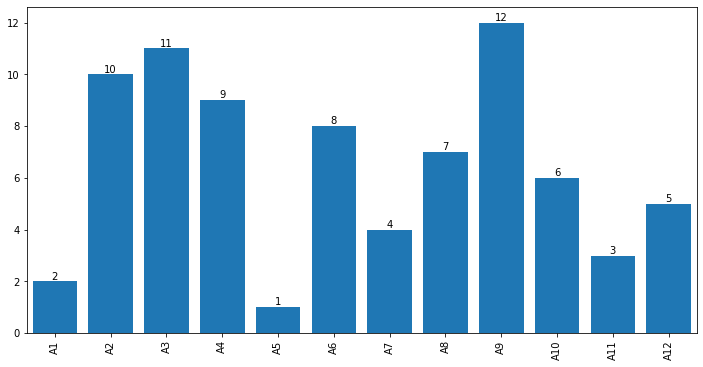

In [4]:
f = FuzzyTopsis(input_matrix, weights, new_criterias)

# calculating the ranking
f.calc()

ranks = f.rank_to_closeness_coefficient()

print("\nRanks\n", ranks)
print("\nVisualization graph:")
f.visualization(ranks) 


In [ ]:
'''import os
import glob
import pandas as pd
os.chdir("/content/")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
li = []
for filename in all_filenames:
    df = pd.read_csv(filename, index_col=None, header=None)
    li.append(df)

combined_csv = pd.concat(li, axis=0, ignore_index=True)
#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames],axis=1, join='inner')
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')
'''